<a href="https://colab.research.google.com/github/rahulkumar1502/ERA-V2/blob/main/ERA_V2_S7_Step_3_Rahul_Kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

Now that our model is not over fitting we shift our focus towards improving accuracy.

Examinig data tells us that certain classes needs to be fixed by rotation, hence as part of data augmentation we can experiment with different rotation degree.

We will also add a LR scheduler to see how we can further optimize our LR.

- Add rotation, we guess that 5-7 degrees should be sufficient
- Add LR Scheduler

Results:
- Parameters: 7,416
- Best Training Accuracy: 99.03
- Best Test Accuracy: 99.44


Analysis:
- Model is not over-fitting now
- Target Accuracy acheived
- Using scheduler for LR worked
- Adding rotation of (-7.0,7.0) decreased our model's accuracy. Rotation of (-3.0,3.0) increased our accuracy but not significantly. (-5.0,5.0) Rotation works the best.
- Further experiments to reduce parameters can be done.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Net3

In [2]:
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16065033.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 579355.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 662188.69it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3954032.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


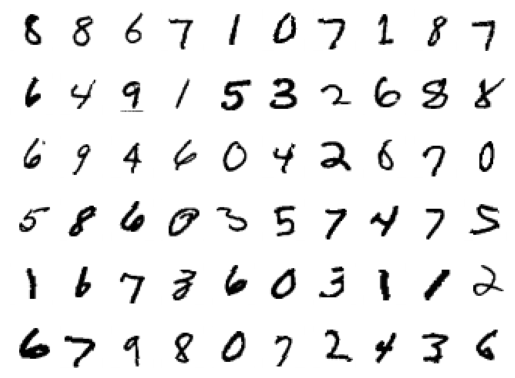

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13036534190177917 Batch_id=468 Accuracy=84.32: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.1635, Accuracy: 9553/10000 (95.53%)

EPOCH: 1


Loss=0.14865584671497345 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]



Test set: Average loss: 0.0765, Accuracy: 9778/10000 (97.78%)

EPOCH: 2


Loss=0.08460081368684769 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]



Test set: Average loss: 0.0458, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.04488466680049896 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0443, Accuracy: 9861/10000 (98.61%)

EPOCH: 4


Loss=0.025816356763243675 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]



Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.026621008291840553 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0427, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.016561731696128845 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0318, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.04650406539440155 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]



Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.033967357128858566 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]



Test set: Average loss: 0.0316, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.07647533714771271 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:24<00:00, 19.38it/s]



Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.010969665832817554 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.03170820325613022 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]



Test set: Average loss: 0.0318, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.014067701064050198 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0305, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.07530615478754044 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0301, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.0679270476102829 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0303, Accuracy: 9916/10000 (99.16%)

